# <span style="color:brown"> **Deep image reconstruction using the PyTorch and SPyRiT packages**

## <span style="color:brown"> **With application to limited-angle computed tomography**

*PyTorch 1.10.1; SPyRiT 2.0.0*

Authors (version 2023): L Amador, E Chen, N Ducros, H-J Ling, K Mom, J Puig, T Grenier, E Saillard,      
Authors (version 2021): N Ducros, T Leuliet, A Lorente Mur, Louise Friot-Giroux
    
Contact: *nicolas.ducros@creatis.insa-lyon.fr*
    
##  <span style="color:brown"> Data download (just once)

In [1]:
import os
if not os.path.isfile("data.zip"):
    !wget "https://www.creatis.insa-lyon.fr/~ducros/spyritexamples/2023_DLMIS/data.zip"
    !unzip -qq data.zip

In [2]:
#!pip install spyrit==3.0.0
#!pip install h5py
#!pip install scikit-image

In [3]:
%matplotlib inline

##  <span style="color:brown"> Imports

In [4]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import scipy.linalg as lin
from PIL import Image, ImageOps
from model_radon import radonSpecifyAngles, vector2matrix
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale
import time

In [5]:
plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 16})

## <span style="color:brown"> Parameters

In [6]:
#- Acquisition
img_size = 64 # image size
pixel_size = 64 #Number of pixels of the sensor

#- Using CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# <span style="color:brown"> **1 - Computed Tomography (CT) and Radon operator**

## Computed Tomography (CT)
Computed tomography (CT) is an imaging modality that reconstructs 2D or 3D objects from attenuation measurements. CT is a technique used in non-destructive inspection but most notably in medical imaging, where attenuation allows the type of tissue (e.g., bone, soft tissue) and structures (e.g., tumors) to be identified. The image formation process can be modelled by the Radon transform.

## <span style="color:brown"> Radon transform
The [Radon transform](https://en.wikipedia.org/wiki/Radon_transform) is an integral transform that returns line integrals over hyperplanes (e.g., along lines for a 2D object). We illustrate this process in a discrete setting below. We consider the projection of a discrete object image $\mathbf{x}$ along a projection ray $(r_j, \theta_k)$, where $\{r_j\}$ is the detector pixel locations and $\theta_k$ the projection angle. The integral  measured for all detector pixels under all projection views is known as the '[sinogram](https://en.wikipedia.org/wiki/Radon_transform#/media/File:Radon_transform_sinogram.gif)'. 

<img src="fig/tomo.png" alt="Projections schem" style="width: 80%;"/>


<font color='blue'>**Q: How does the sinogram of a point object (i.e., an image with only one nonzero pixel) look like? Complete the code below**
    
<font color='green'>**Help: Create a (Q x Q) image with only one pixel set to 1. Set all the other pixels to 0.**</font>

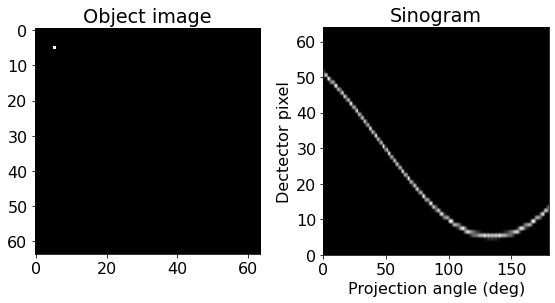

In [7]:
# Vector with acquired angles
theta = np.linspace(0., 180., 181)

# Image with a single pixel set to one (point response function)
example = np.zeros((img_size, img_size)) #COMPLETE
example[5,5] = 1 # -----------------------DELETE HERE

# Sinogramm (CT measurements from object image)
sinogram = radon(example, theta, circle=False)
sinogram = rescale(sinogram, scale=(pixel_size/sinogram.shape[0],1), mode='reflect')

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Object image")
ax1.imshow(example, cmap=plt.cm.Greys_r)

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Dectector pixel")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

<font color='blue'>**Q: Explain the 'sinogram' terminology.**</font>

<font color='red'> **A: The point response of the Radon transform is a sine. Therefore, any sinogram can be seen as the weighted sum of many sines, each of them originating from one of the pixels in the object image.**</font>

## <span style="color:brown"> The Radon operator
The Radon transform is a linear operator. Therefore, the sinogram $\textbf{m}$ can be simply obtained as the matrix vector product $\textbf{m} = \textbf{Af}$, where $\textbf{A}$ represents the discrete Radon (forward) operator and $\textbf{f}$ is the object image. Both $\textbf{m}$ and $\textbf{f}$ are column vectors; $\textbf{m}$ contains all the measurements, $\textbf{f}$ all the image pixels. $\textbf{A}$ is a matrix, whose dimensions match with the dimentions of $\textbf{m}$ and $\textbf{f}$.

This is illustrated below. 
    
<img src="fig/def_var.png" alt="m and A" style="width: 100%;"/>

### <span style="color:brown"> Creating the operator

Our objective here is to create this forward operator $A$ for a toy example of images of size $16\times 16$. 

<font color='blue'>**Q: Based on the explanation above, complete the code below to create the matrix 'A_example'**</font>.

<font color='green'>**Help: First, determine the size of the Radon matrix**</font>

<font color='green'>**Help: Next, generate one column of the Radon matrix at a time using the 'radon' function**</font>

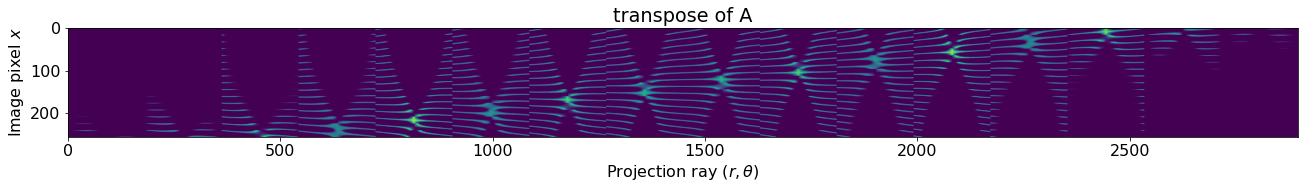

In [8]:
total_angles = 181

# Define an empty matrix A
img_size = 16
pixel_size = 16
A = np.zeros((pixel_size*total_angles, img_size*img_size)) #COMLPLETE

# Build the forward operator, one column at a time. 
for i in range(img_size):
    for j in range(img_size):
        # Activating a single pixel of the object image
        image = np.zeros((img_size,img_size)) ##COMPLETE
        image[i,j] = 1 ##COMLPETE
        
        # Radon transform
        sinogram = radon(image, theta, circle=False) ##COMPLETE
        sinogram = rescale(sinogram, scale=(pixel_size/sinogram.shape[0],1), mode='reflect')
        
        # Concatenating results in matrix A 
        A[:,img_size*i+j] = np.reshape(sinogram, (pixel_size*total_angles, ))

# A matrix visualisation
fig, ax = plt.subplots(figsize=(100, 2))
ax.imshow(np.transpose(A))
ax.set_title("transpose of A")
ax.set_xlabel(r"Projection ray $(r, \theta)$")
ax.set_ylabel(r"Image pixel $x$")
plt.show()

<font color='blue'> **Q: How does the Radon matrix $\mathbf{A}$ look like? Especially, why is it sparse?**</font>

<font color='red'> **Each row corresponds to one pixel position in the image domain. Each column corresponds to one projection ray in the sinogram. The matrix is sparse because only few pixels in the object image contribute to the measurement obtained for a given detector pixel under a given projection angle. For instance, at projection angle 0, there are only 16 pixels in the image that contribute to the measurement in each detector pixel, which we can observe with the "lines" in the forward matrix.**</font>

### <span style="color:brown"> Testing the resulting matrix

<font color='blue'>**Q: Check that the forward operator corresponds to Radon transform. For this, complete the code below to compare the sinograms obtained with the radon function and using the matrix-vector product**</font>

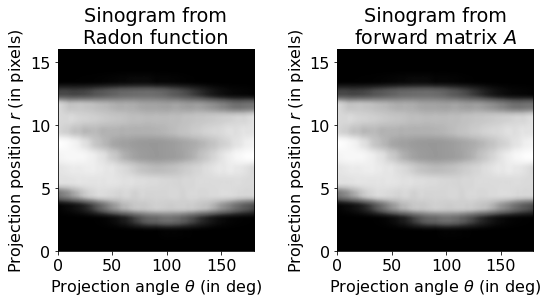

In [9]:
phantom = shepp_logan_phantom()
phantom = rescale(phantom, scale=(img_size/phantom.shape[0]), mode='reflect')

# Radon transform with skimage function
radon1 = radon(phantom, theta, circle=False) ## COMPLETE
radon1 = rescale(radon1, scale=(pixel_size/radon1.shape[0], 1), mode='reflect') ##COMPLETE

# Radon transform as a matrix-vector product ## COMPLETE
f = np.reshape(phantom, (-1, 1))
m = np.matmul(A,f)
radon2 = np.reshape(m, (pixel_size,total_angles)) 

# Plots ##COMPLETE THE PLOT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title(r"Sinogram from" + "\nRadon function")
ax1.set_xlabel(r"Projection angle $\theta$ (in deg)")
ax1.set_ylabel(r"Projection position $r$ (in pixels)")
ax1.imshow(radon1, cmap=plt.cm.Greys_r, extent=(0, 180, 0, radon1.shape[0]), aspect='auto')

ax2.set_title(r"Sinogram from" + "\n" + r"forward matrix $A$")
ax2.set_xlabel(r"Projection angle $\theta$ (in deg)")
ax2.set_ylabel(r"Projection position $r$ (in pixels)")
ax2.imshow(radon2, cmap=plt.cm.Greys_r, extent=(0, 180, 0, radon2.shape[0]), aspect='auto')

fig.tight_layout()
plt.show()

### <span style="color:brown"> Inverse matrix
We now aim at retrieving $\textbf{f}$ from the measurements $\textbf{m}$. 
    
A basic idea could be to invert the matrix $\textbf{A}$. However, the matrix is not square and is badly [conditioned](https://en.wikipedia.org/wiki/Condition_number). Therefore, we will consider the Moore-Penrose [pseudo inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse), the most widely known generalization of the inverse matrix.
     
The pseudo-inverse of a matrix $\textbf{A}$, denoted $\textbf{A}^+$, is a matrix that provides a least squares solution to the invertion of the linear system $\textbf{m} = \textbf{Af}$. We refer to $\tilde{\textbf{f}} = \textbf{A}^+ \textbf{m}$ as the pseudo inverse solution.

<img src="fig/pinv.png" alt="m and A" style="width: 100%;"/>    
    
<!-- It can be shown that if $Q_1 \Sigma Q_2^T = A$ is the singular value decomposition of A, then $A^+ = Q_2 \Sigma^+ Q_1^T$, where $Q_{1,2}$ are orthogonal matrices, $\Sigma$ is a diagonal matrix consisting of $A$’s so-called singular values (followed typically by zeros), and $\Sigma^+$ is the diagonal matrix consisting of the reciprocals of $A$’s singular values (again, followed by zeros). [1]

[1] G. Strang, Linear Algebra and Its Applications, 2nd Ed., Orlando, FL, Academic Press, Inc., 1980, pp. 139-142. -->


<font color='blue'>**Q: Complete the code to reconstruct $\textbf{f}$ from $\textbf{m}$ by computing the least square solution using two different methods that you will compare**</font>

<font color='green'>**Help: First, use the pseudo inverse of $\textbf{A}$, which can be computed using this sciPy [function](https://docs.scipy.org/doc//numpy-1.14.1/reference/generated/numpy.linalg.pinv.html).**</font>

<font color='green'>**Help: Next, use a linear solver to invert the system $\textbf{m} = \textbf{Af}$. See for instance, this sciPy [function](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.linalg.lstsq.html)**</font>

Recon with pseudoinverse: 0.097 + 0.0004 s
Recon with solver: 0.056 s


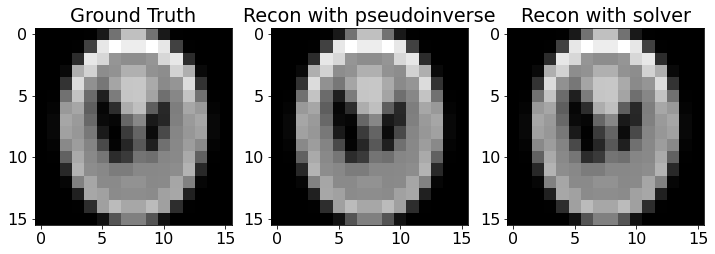

In [11]:
# Use the computed sinogram
sinogram = np.reshape(radon1, (-1, 1))

# Compute the pseudoinverse
t0 = time.perf_counter()
pinv = lin.pinv(A) # COMPLETE
t0 = time.perf_counter() - t0

# Reconstruct with pseudoinverse 
t1 = time.perf_counter()
rec_pi = np.reshape(np.dot(pinv, sinogram), (img_size,img_size)) # COMPLETE
t1 = time.perf_counter() - t1
print(f'Recon with pseudoinverse: {t0:.3f} + {t1:.4f} s')

# Reconstruct with a linear solver
t2 = time.perf_counter()
rec_solv = np.reshape(lin.lstsq(A, sinogram)[0], (img_size,img_size)) # COMPLETE
t2 = time.perf_counter() - t2
print(f'Recon with solver: {t2:.3f} s')

# Display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
ax1.set_title(r"Ground Truth")
ax1.imshow(phantom, cmap=plt.cm.Greys_r)

ax2.set_title(r"Recon with pseudoinverse")
ax2.imshow(rec_pi, cmap=plt.cm.Greys_r)

ax3.set_title(r'Recon with solver')
ax3.imshow(rec_solv, cmap=plt.cm.Greys_r)

<font color='blue'>**Q: Which approach is faster? When should we use one or the other?**</font>

<font color='red'>**A: reconstruction with the solver is slightly faster than with the pseudo inverse. Note that these computation time depend on your machine. However, once the pseudo inverse is computed, it can be used to reconstruct new data in a very short time (e.g., few milliseconds), while the solver will be significantly slower (e.g., ~100 ms).**</font>

# <span style="color:brown"> **2 - Limited-angle acquisition and reconstruction**

## <span style="color:brown"> Forward operator 

To limit the acquisition time, it may be desirable to acquire only some of the projection rays (i.e, reduce the number of projection angles or detector pixels). We investigate here the behaviour of the pseudoinverse reconstruction for limite-angle acquisition. The limited-angle forward operator can be obtained by discarding some of the rows of the full forward operator, as illustrated below.
    
<img src="fig/Explain_a_reduced.PNG" alt="m and A" style="width: 80%;"/>   

From now on, we will consider images of size $64 \times 64$. In the code below, we will consider the acquisition of 20 projection angles only. We first load the full forward matrix that has been pre-computed. Only some of the rows of the full forward matrix are kept to build the limited-angle forward operator `A_reduced`.

<font color='blue'> **Q: What are the dimensions of the limited-angle forward operator `A_reduced`? Complete the code below**</font>

In [12]:
# Data path
data_root = './data/'
saved_data = data_root + 'matrices/'

img_size = 64 # image size
pixel_size = 64 #Number of pixels of the sensor

radon_matrix_path = saved_data + 'Q{}_D{}.npy'.format(img_size, pixel_size)
#radon_matrix_path = saved_data + 'radon181x64x64x64.npy'
A = np.load(radon_matrix_path)
A = torch.from_numpy(A)
A = A.type(torch.FloatTensor)

# Compute the reduced forward matrix
nbAngles = 20
#Areduced = model_radon.radonSpecifyAngles(A, model_radon.generateAngles(nbAngles))
#Areduced = Areduced.type(torch.FloatTensor)
Areduced = radonSpecifyAngles(A, nbAngles)
Areduced = torch.from_numpy(Areduced)
Areduced = Areduced.type(torch.FloatTensor)

# print dimension of forward operators
print(A.shape) # COMPLETE
print(Areduced.shape) # COMPLETE

torch.Size([11584, 4096])
torch.Size([1280, 4096])


<font color='red'>**A: A_reduced is of size (20x64,64x64)**</font>

<font color='blue'> **Q: Are `A` and `A_reduced` still numpy arrays? What is their type? Why changing?**</font>

In [13]:
# Type of forward matrices
print(type(A)) # COMPLETE
print(type(Areduced)) # COMPLETE

<class 'torch.Tensor'>
<class 'torch.Tensor'>


<font color='red'>**A: We now manipulate them as torch tensors for integrating them into neural networks**</font>

## <span style="color:brown"> Reconstruction 

We will now compare the quality of the reconstructions obtained from full-angle and limited-angle measurements.

<font color='blue'> **Q: Complete the code below to compute the sinograms with both forward operators**</font>

<font color='green'> **Help: You can use the torch [matrix-vector mutiplication](https://pytorch.org/docs/stable/generated/torch.mv.html)** </font>

In [14]:
# Load the image
im = Image.open("fig/image.png")
im = ImageOps.grayscale(im)

# Preprocess the image
im_array = np.asarray(im)
im_array = im_array.astype(np.float32)
im_array = 2*(im_array)/255 - np.ones([64,64])

# Conversion of object image to torch tenser
f = torch.from_numpy(im_array)
f = f.view(1,img_size**2);
f = f.t()
f = f.type(torch.FloatTensor)

# Simulate the measurements with full angle and limited angle configurations
m_reduced = torch.mv(Areduced,f[:,0]) ##COMPLETE
m_perfect = torch.mv(A,f[:,0])        ##COMPLETE

<font color='blue'> **Q: Reconstruct the image with the pseudoinverse and plot them.**</font>

<font color='green'> **Help: You can use the torch [pseudo inverse](https://pytorch.org/docs/stable/generated/torch.pinverse.html).** </font>

<font color='green'> **Warning: Play with the 'rcond' parameter to compute the pseudo inverse of 'Areduced'**</font>


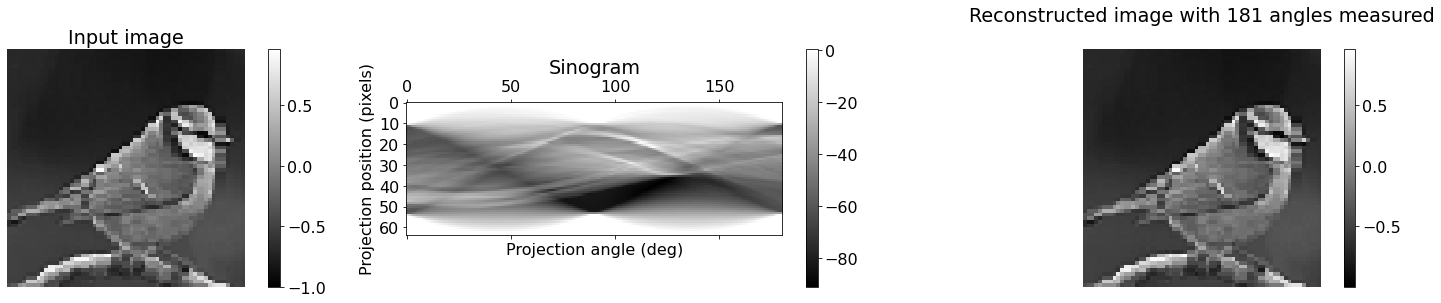

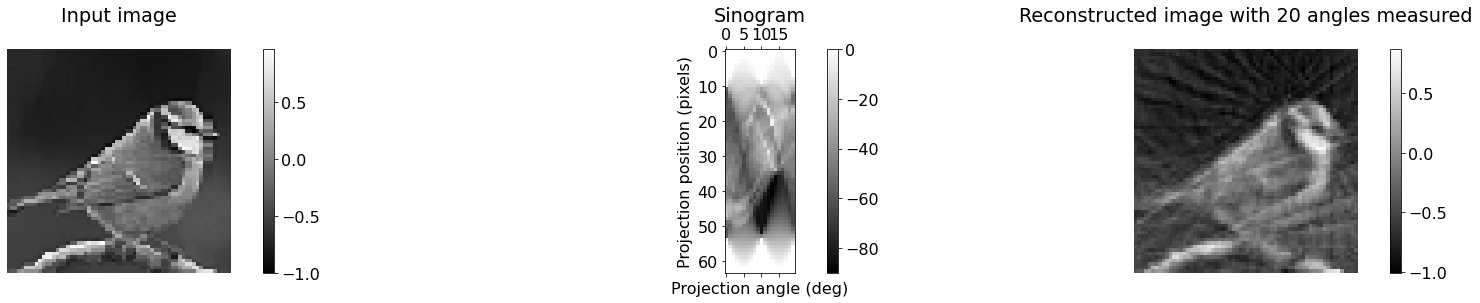

In [15]:
# Compute pseudo-inverse
pinvA = torch.pinverse(A)         ##COMPLETE
pinvAreduced = torch.pinverse(Areduced,1e-6) ##COMPLETE

# Full-angle reconstruction
f_perfect = torch.mv(pinvA, m_perfect) ##COMPLETE #should be a 1D vector here
f_perfect_array = vector2matrix(f_perfect, [img_size,img_size]) # Resize to a 2D shape
f_perfect_array = np.transpose(f_perfect_array)

# Limited angle reconstruction
f_reconstruct = torch.mv(pinvAreduced, m_reduced) ##COMPLETE
f_reconstruct_array = vector2matrix(f_reconstruct, [img_size,img_size]) # Resize to a 2D shape
f_reconstruct_array = np.transpose(f_reconstruct_array)

#============ Display results ================================
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.imshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
m_perfect_array = vector2matrix(m_perfect, [total_angles,pixel_size])
pcm2 = ax2.matshow(m_perfect_array, cmap='gray')

ax3.set_title("Reconstructed image with 181 angles measured")
pcm3 = ax3.matshow(f_perfect_array, cmap='gray')
ax3.set_axis_off()

fig.colorbar(pcm1,ax=ax1)
fig.colorbar(pcm2,ax=ax2)
fig.colorbar(pcm3,ax=ax3)
fig.tight_layout()

fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 4.5))

ax1.set_title("Input image")
pcm1 = ax1.matshow(im_array, cmap='gray')
ax1.set_axis_off()

ax2.set_title("Sinogram")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
m_array = vector2matrix(m_reduced, [nbAngles,pixel_size])
pcm2 = ax2.matshow(m_array, cmap='gray')

ax3.set_title("Reconstructed image with 20 angles measured")
pcm3 = ax3.matshow(f_reconstruct_array, cmap='gray')
ax3.set_axis_off()

fig2.colorbar(pcm1,ax=ax1)
fig2.colorbar(pcm2,ax=ax2)
fig2.colorbar(pcm3,ax=ax3)
fig2.tight_layout()

plt.show()

<font color='blue'> **Q: How do the full-angle and limited-angle reconstructions compare?**</font>

<font color='red'>**A: Many artefacts are present; most details are lost. The pseudo-inverse matrix leads to poor image quality for limited-angle reconstruction**</font>

## <span style="color:brown"> Influence of the number of angles

We have observed the degradation of the image quality due to limited-angle measurements. We will now investigate the influence of the numbers of projection angles.

<font color='blue'> **Complete and run the code below. NB: this takes about 60 seconds**</font>

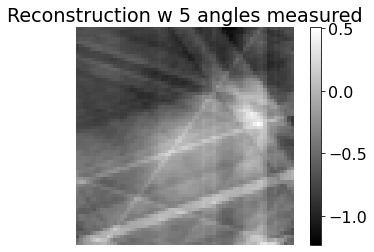

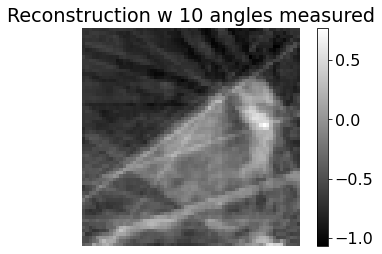

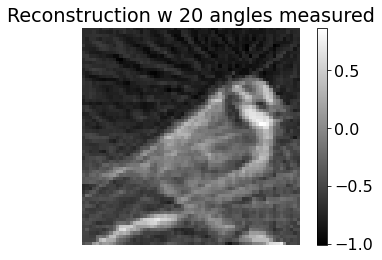

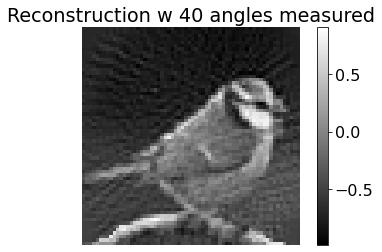

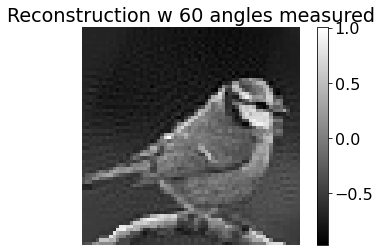

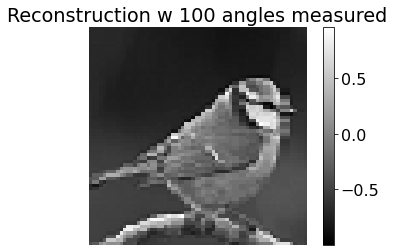

In [16]:
listAngles = [5, 10, 20, 40, 60, 100]

##PERFORM THE WHOLE LOOP
for ang in listAngles:

    Areduced = radonSpecifyAngles(A, ang)
    Areduced = torch.from_numpy(Areduced)
    Areduced = Areduced.type(torch.FloatTensor)
    
    # Compute the pseudoinverse    
    pinvAreduced = torch.pinverse(Areduced, 1e-5)  # COMPLETE
    
    # Simulate the measurements
    m = torch.mv(Areduced,f[:,0])
    
    # Reconstruct the image
    f_reconstruct = torch.mv(pinvAreduced,m)
    
    # Reshape into a 2D mage
    f_reconstruct_array = vector2matrix(f_reconstruct, [img_size,img_size])
    f_reconstruct_array = np.transpose(f_reconstruct_array)
    
    # Display results
    plt.imshow(f_reconstruct_array, cmap='gray')
    plt.title(f'Reconstruction w {ang} angles measured')
    plt.colorbar()
    plt.axis('off')
    plt.show()

<font color='blue'> **Q: What is the minimum number of measurement angles that can be reconstucted using the pseudo-inverse matrix?** </font>

<font color='red'>**A: More than 60 angles are necessary. NB: the computation time of the pseudo inverse matrix increases dramatically with the number of angles, which is due the [computational compexity of singular value decomposition](https://stackoverflow.com/questions/58191604/what-is-the-time-complexity-of-the-pseudo-inverse-in-pytorch-i-e-torch-pinvers)**</font>

# <span style="color:brown"> **3 - Deep image reconstruction**
## <span style="color:brown"> Framework
    
Deep image reconstruction aims to design a non-linear mapping (i.e., neural network) $\mathcal{G}_{\omega}$ such that 

\begin{equation*}
\mathcal{G}_{\omega}(\mathbf{m}) \approx \mathbf{f},
\end{equation*}

where $\omega$represents the parameters of the network. The parameters are optimized during the training phase to minimize the cost function

\begin{equation*}
\omega^* = \underset{\omega}{\text{arg min}} \sum_{\ell=0}^{S-1} \| \mathcal{G}_\omega(\mathbf{m}^{(\ell)}) - \mathbf{f}^{(\ell)}\|^2_2 + \mathcal{R}(\omega),
\end{equation*}
where $\{\mathbf{m}^{(\ell)} , \mathbf{f}^{(\ell)}\}$, $0 \le \ell \le L-1$ are the measurement-image pairs of the training database, and $\mathcal{R}$ is a regularization function that stabilizes training. For this study we will consider $\mathcal{R}(.) = \alpha \|.\|^2_2$, where $\alpha$ is a positive constant that will impact how important $\mathcal{R}$ is with respect to the rest of the cost function.

## <span style="color:brown"> Network architecture

As illustrated below, we choose to map the sinogram $\mathbf{m}$ into the image domain (see $\tilde{\mathbf{f}}$) to benefit convolutional layers are particularly powerful for image denoising and artefact correction.

<img src="fig/network.png" alt="m and A" style="width: 100%;"/> 

<font color='blue'>**Q: Why do we map the sinogram into the image domain before applying convolutional layers? Why do we use the Moore-Penrose pseudo-inverse rather than learning this mapping?**</font>

<font color='red'>**A: First, convolutional layers have shown great success in exploiting spacial redundancies of natural images, so we would like to apply these layers in the image domain. While several studies have shown that convolutional layers can be used on sinograms too, image-domain processing is a safe choice. Second, learning the measurement to image domain mapping, would require learning a lot of parameters (i.e, $D\times \Theta \times, Q^2$ parameters) and the resulting network may be more sensitive to noise.**</font>

In [18]:
from spyrit.core.recon import PinvNet
from spyrit.core.train import train_model, Weight_Decay_Loss, load_net
from spyrit.core.nnet import ConvNet
from spyrit.core.meas import Linear


test_amt = 4
nbAngles = 20

A = np.load(radon_matrix_path)

Areduced = radonSpecifyAngles(A, nbAngles)
Areduced_torch = torch.Tensor((Areduced)).to(device)
meas = Linear(Areduced_torch, meas_shape=(img_size,img_size))
denoi = ConvNet()
model = PinvNet(meas, nn.Identity(), denoi, store_H_pinv=True)
model = model.to(device)

print(model)

PinvNet(
  (acqu_modules): Sequential(
    (acqu): Linear(
      (noise_model): Identity()
    )
  )
  (recon_modules): Sequential(
    (prep): Identity()
    (pinv): PseudoInverse(
      (meas_op): Linear(
        (noise_model): Identity()
      )
    )
    (denoi): ConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
  )
)


<font color='blue'> **Q: How does `model` relate to the network architecture depicted above?**</font>

<font color='green'>**Tip: Check the ouptput of `print(model)`**</font>

<font color='red'>**'acqu' represents the forward module that simulates measurements during the training phase; 'meas_op.H' represents the forward matrix $\mathbf{A}$; 'pinv' compute the pseudo inverse solution; 'recon' represents the convolutional layers in the image domain**</font>

## <span style="color:brown"> Importing the dataset

In [19]:
batch_size=256

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.ImageFolder(root=data_root+"train", transform=transform)
trainloader =     torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)

testset = torchvision.datasets.ImageFolder(root=data_root+"test", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train': trainloader, 'val': testloader}
inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

<font color='blue'>**Q: What is the shape of the database 'input' variable? What does each dimension correspond to?**</font>

In [20]:
print("input images shape: ", inputs.shape)  # COMPLETE
outputs = model(inputs)
print("output images shape: ", outputs.shape)

input images shape:  torch.Size([256, 1, 64, 64])
output images shape:  torch.Size([256, 1, 64, 64])


<font color='red'>**A: \[Batch_size, channels, height, width\]. We manipulate batches that contain 256 images of size 64 x 64; 'channels' = 1 indicates that images are grascale.**</font>

<font color='blue'>**Q: Explain the line 'transforms.Normalize([0.5], [0.5])'. Why is it important?**</font>

<font color='red'>**A: We normalize the data to 0 mean and unit variance. Considering normalized data stabilizes and accelerates the optimization of the parameters of the network. Normalisation is also fondamental when the raw data extend over several orders of magnitude.**</font>

## <span style="color:brown"> Training a reconstruction network from scratch (for 3 epochs)

<font color='blue'>Run the cell below to train the convolutional layers. NB: training takes about two minutes</font>

In [21]:
lr=1e-3
step_size=20
gamma=0.2
model_root='./data/nets/'

loss = nn.MSELoss();
criterion = Weight_Decay_Loss(loss);
optimizer = optim.Adam(model.parameters(), lr=lr);
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model, train_info =  train_model(model, criterion, optimizer, scheduler, 
                                dataloaders, device, model_root, 
                                num_epochs=3, disp=True) 
 
model.eval()

Number of trainable parameters: 8129
Total number of parameters: 5251009
Memory requirement: 21004036 bytes
[train] [Epoch 1/3] [Batch 80/80] [Loss: 0.013774] ETA: 0:01:27.386186 
train Loss: 14.2075 
[val] [Epoch 1/3] [Batch 4/4] [Loss: 0.046441] ETA: 0:00:05.652210 
val Loss: 10.9200 
[train] [Epoch 2/3] [Batch 80/80] [Loss: 0.008784] ETA: 0:00:49.547724 
train Loss: 2.6054 
[val] [Epoch 2/3] [Batch 4/4] [Loss: 0.031470] ETA: 0:00:03.309062 
val Loss: 7.3594 
[train] [Epoch 3/3] [Batch 80/80] [Loss: 0.007194] ETA: 0:00:00.588244 
train Loss: 1.9254 
[val] [Epoch 3/3] [Batch 4/4] [Loss: 0.028436] ETA: 0:00:00.698252 
val Loss: 6.7044 
Training complete in 6m 11s
Best val Loss: 6.704383


PinvNet(
  (acqu_modules): Sequential(
    (acqu): Linear(
      (noise_model): Identity()
    )
  )
  (recon_modules): Sequential(
    (prep): Identity()
    (pinv): PseudoInverse(
      (meas_op): Linear(
        (noise_model): Identity()
      )
    )
    (denoi): ConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      )
    )
  )
)

<font color='blue'>**Q: Complete the code below to compare the ground-truth, pseudo-inverse, and the deep solutions.**</font>

<font color='green'>**Tip1: Check the SPyrit documentation to compute the pseudoinverse solution from `model`.**</font>

<font color='green'>**Tip2: Torch tensors may be in the GPU memory**</font>

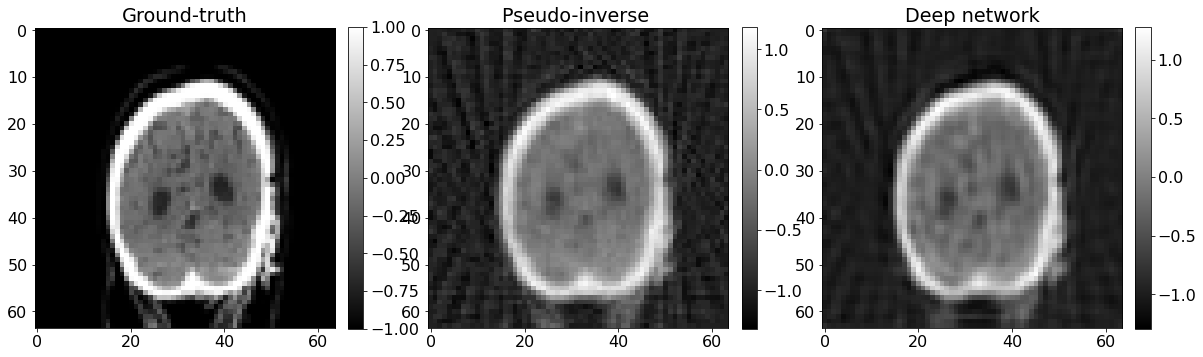

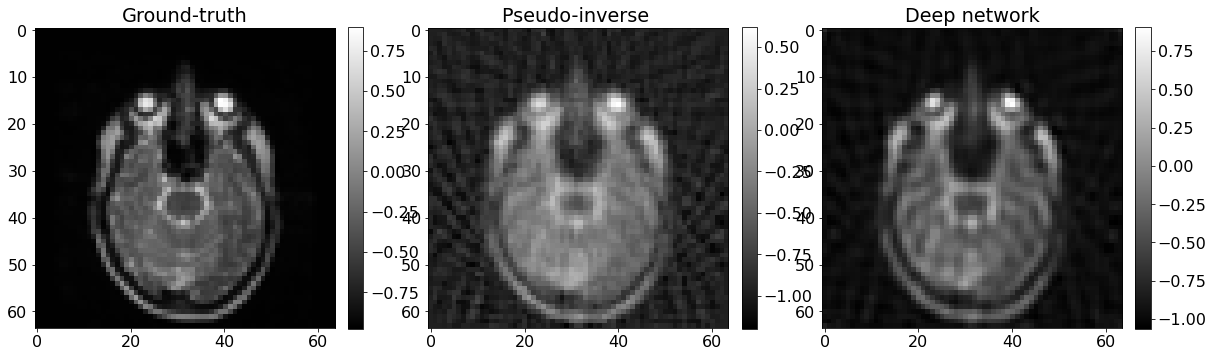

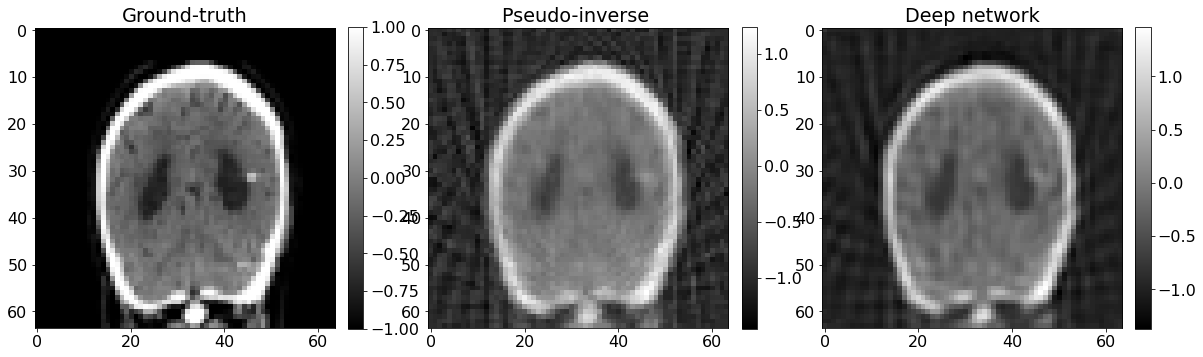

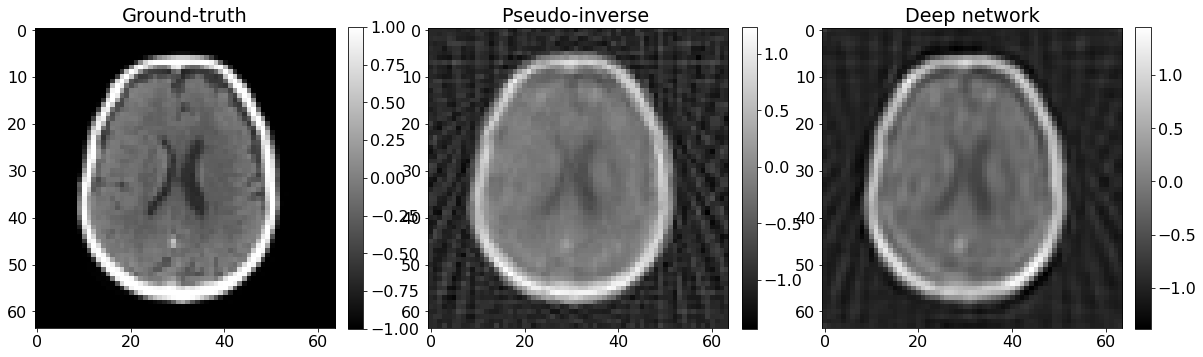

In [22]:
with torch.no_grad():
    for index in range(test_amt):
        
        # Random image in STL10
        np.random.seed(index)
        i_test = np.random.randint(0, inputs.shape[0])
       
        
        mes = model.acquire(inputs)
        rec_pinv = model.reconstruct_pinv(mes).cpu() #Complete here: rec_pinv = model.XXXXX(mes).XXXX
        rec_net = model.reconstruct(mes).cpu() #Complete here: rec_net = model.XXXXXXX(mes).XXXX
        
        # Plots
        fig, axs = plt.subplots(1, 3, figsize =(20,10))
        fig.suptitle('', fontsize=16)
        
        ax = axs[0]
        ax.set_title("Ground-truth")
        aff = ax.imshow(inputs[i_test, 0, :, :].cpu(), cmap='gray')
        fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
    
        ax = axs[1]
        ax.set_title("Pseudo-inverse ")
        aff = ax.imshow(rec_pinv[i_test, 0, :, :], cmap='gray') 
        fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
    
        ax = axs[2]
        ax.set_title("Deep network")
        aff = ax.imshow(rec_net[i_test, 0, :, :], cmap='gray')
        fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
        plt.show()

<font color='blue'>**Q: How do the pseudo inverse solution and network output compare?**</font>

<font color='red'>**A: After only a few epochs, the artefacts of the pseudo inverse solution are significantly reduced. However, the output of the networks is oversmooth**</font>

## <span style="color:brown"> Testing a trained model
    
Here we load networks that we have already trained for larger numbers of epochs
    
<font color='blue'> **Run the code below**</font>

In [30]:
num_epoch = 100
learning_rate = 1e-3
step_size = 10
gamma = 0.5
batch_size = 512
regularisation = 1e-7
model_root='./data/nets/'

nbAngles = 20

inputs, labels = next(iter(dataloaders['val']))
inputs = inputs.to(device)

# Network filename
suffix = 'Q_{}_D_{}_T_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(
    img_size, pixel_size, nbAngles, num_epoch, 
    learning_rate, step_size, gamma, 
    batch_size, regularisation)
title = model_root + 'NET_' + suffix

# Loading the model
Areduced = radonSpecifyAngles(A, nbAngles)
Areduced_torch = torch.Tensor(Areduced).to(device)
meas = Linear(Areduced_torch, meas_shape=(img_size,img_size))
denoi = ConvNet()
model = PinvNet(meas, nn.Identity(), denoi, store_H_pinv=True)
model = model.to(device)
load_net(title, model, device = device)

Model not found at ./data/nets/NET_Q_64_D_64_T_20_epo_100_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07


  <font color='blue'> **Run the code below**</font>

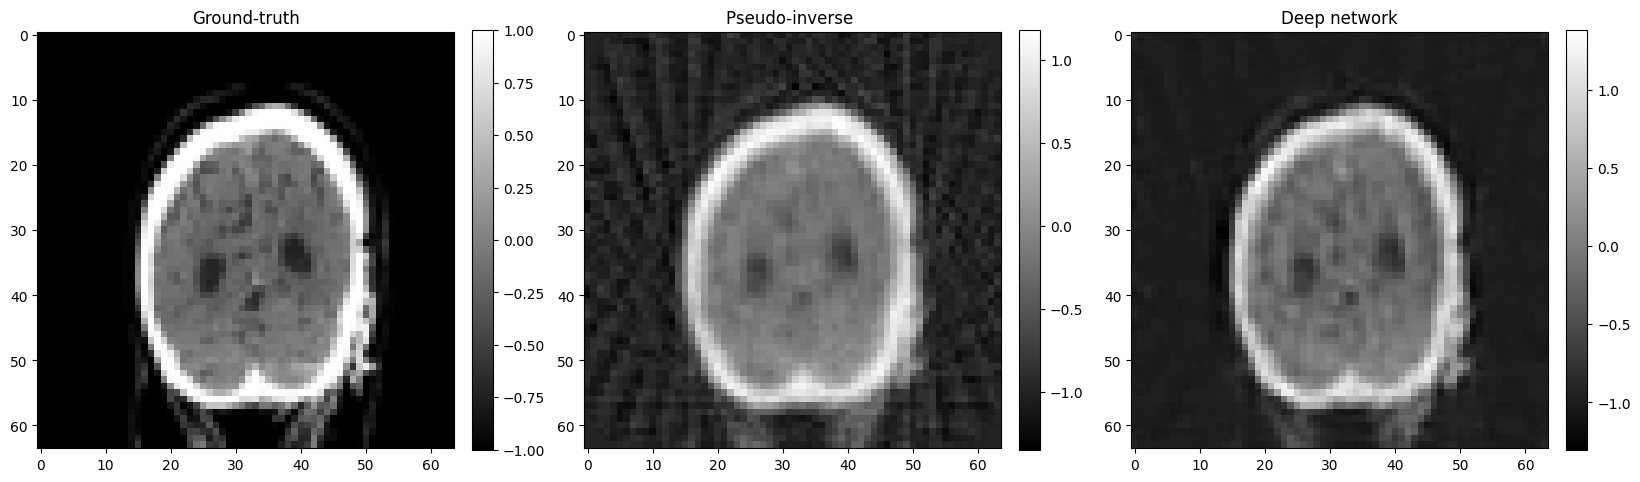

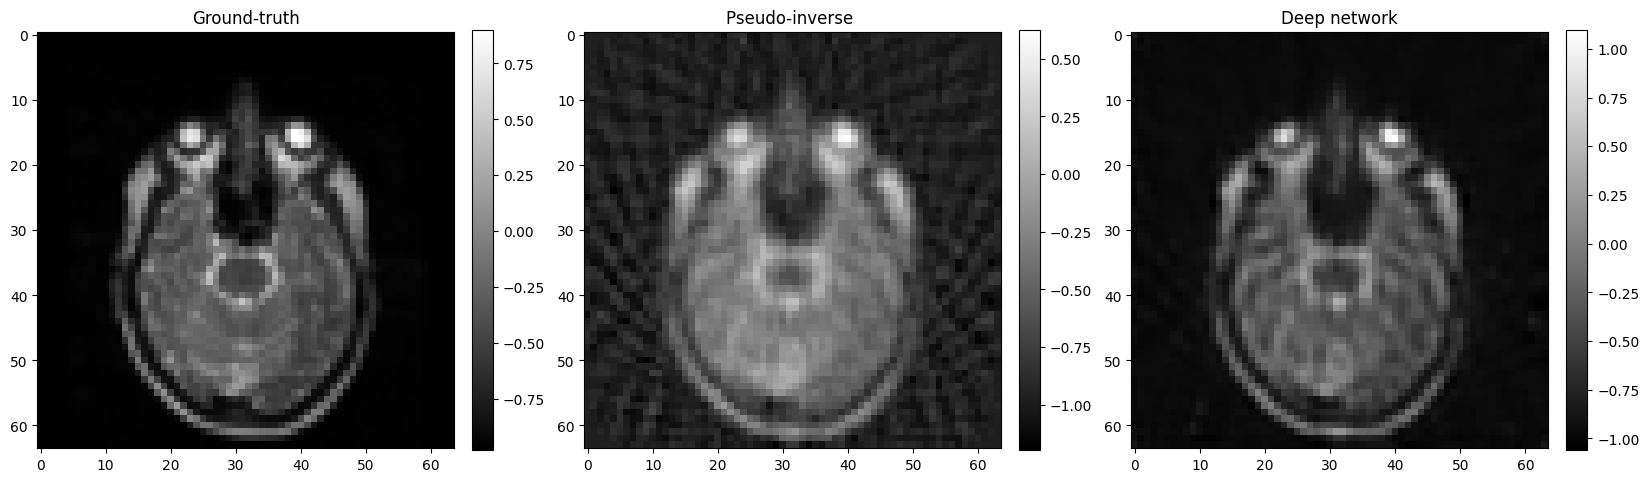

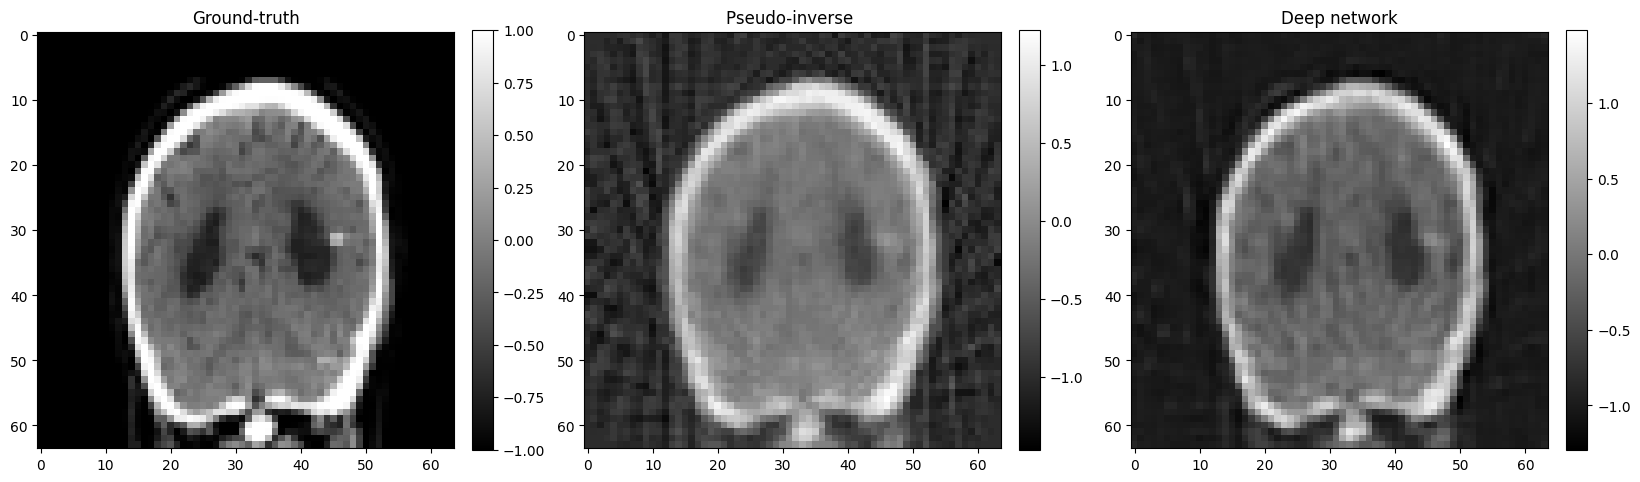

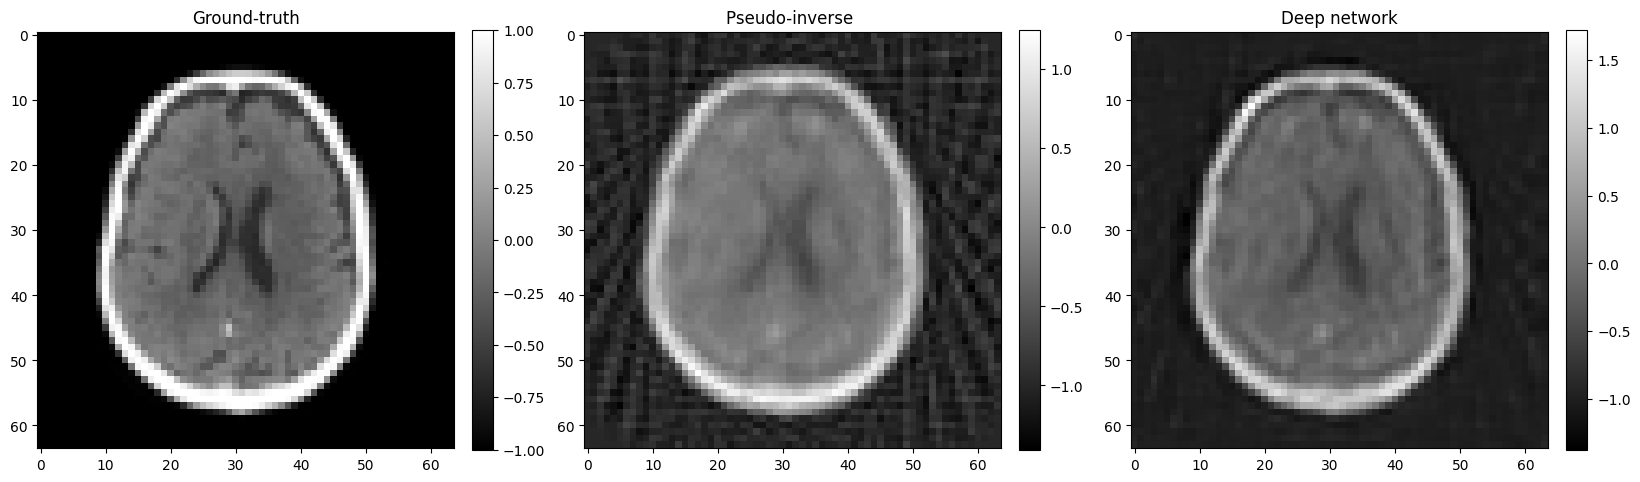

In [22]:
test_amt = 4
with torch.no_grad():
    for index in range(test_amt):
        # Choosing random image in STL10
        np.random.seed(index)
        i_test = np.random.randint(0, inputs.shape[0])
        
        
        mes = model.acquire(inputs) 
        rec_pinv = model.reconstruct_pinv(mes) #Complete here: rec_pinv = model.XXXXX(mes)
        rec_net = model.reconstruct(mes).detach() #Complete here: rec_net = model.XXXXXX(mes).XXXXXX
        
        # Plots
        fig, axs = plt.subplots(1, 3, figsize =(20,10))
        fig.suptitle('', fontsize=16)
        
        ax = axs[0]
        ax.set_title("Ground-truth")
        aff = ax.imshow(inputs[i_test, 0, :, :].cpu(), cmap='gray') 
        fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
        
        ax = axs[1]
        ax.set_title("Pseudo-inverse ")
        aff = ax.imshow(rec_pinv[i_test, 0, :, :].cpu(), cmap='gray') 
        fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
        
        ax = axs[2]
        ax.set_title("Deep network")
        aff = ax.imshow(rec_net[i_test, 0, :, :].cpu(), cmap='gray') 
        fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
        plt.show()

<font color='blue'>**Q: What is the impact of training a deep neural network until convergence?**</font>

<font color='red'>**A: The background exhibits much fewer artifacts while the object is sharper**</font>

## <span style="color:brown"> Influence of the number of projection angles
    
Here, we load several networks that we have already trained for different numbers of projection angles
    
<font color='blue'> **Complete and run the code below. You can also try to reconstruct different images in the batch**</font>

Acquisition of 20 angles
Model Loaded: ./data/nets/NET_Q_64_D_64_T_20_epo_100_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07


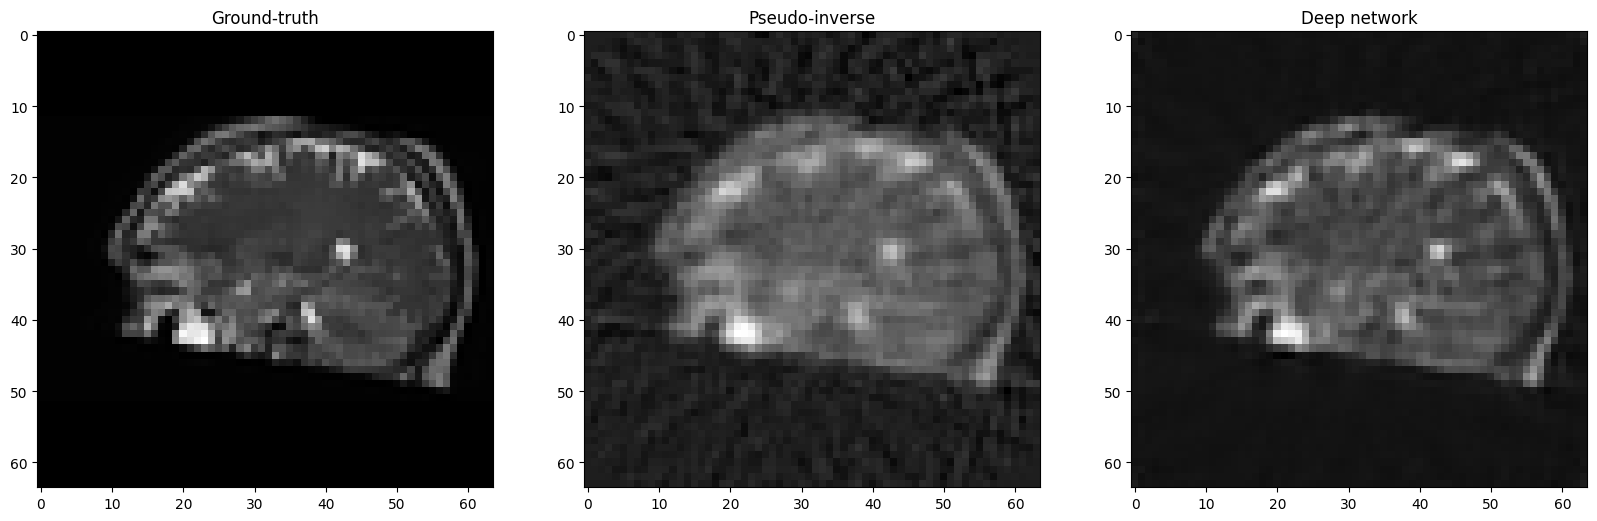

Acquisition of 40 angles
Model Loaded: ./data/nets/NET_Q_64_D_64_T_40_epo_100_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07


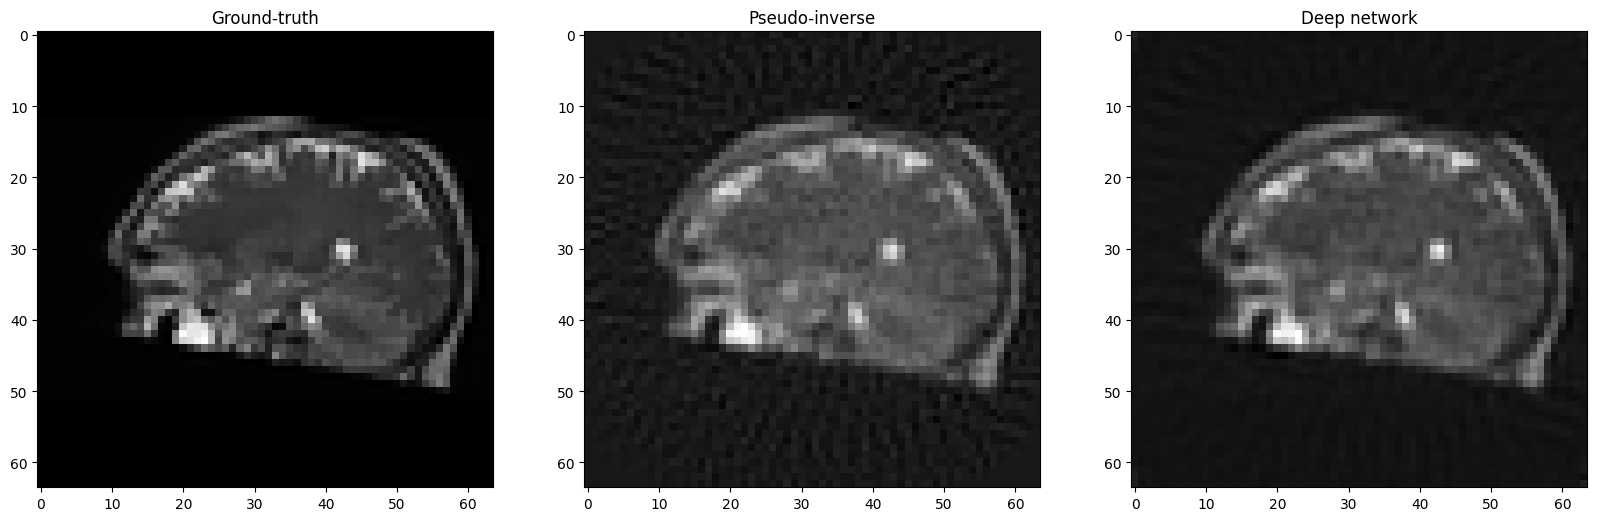

Acquisition of 60 angles
Model Loaded: ./data/nets/NET_Q_64_D_64_T_60_epo_100_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07


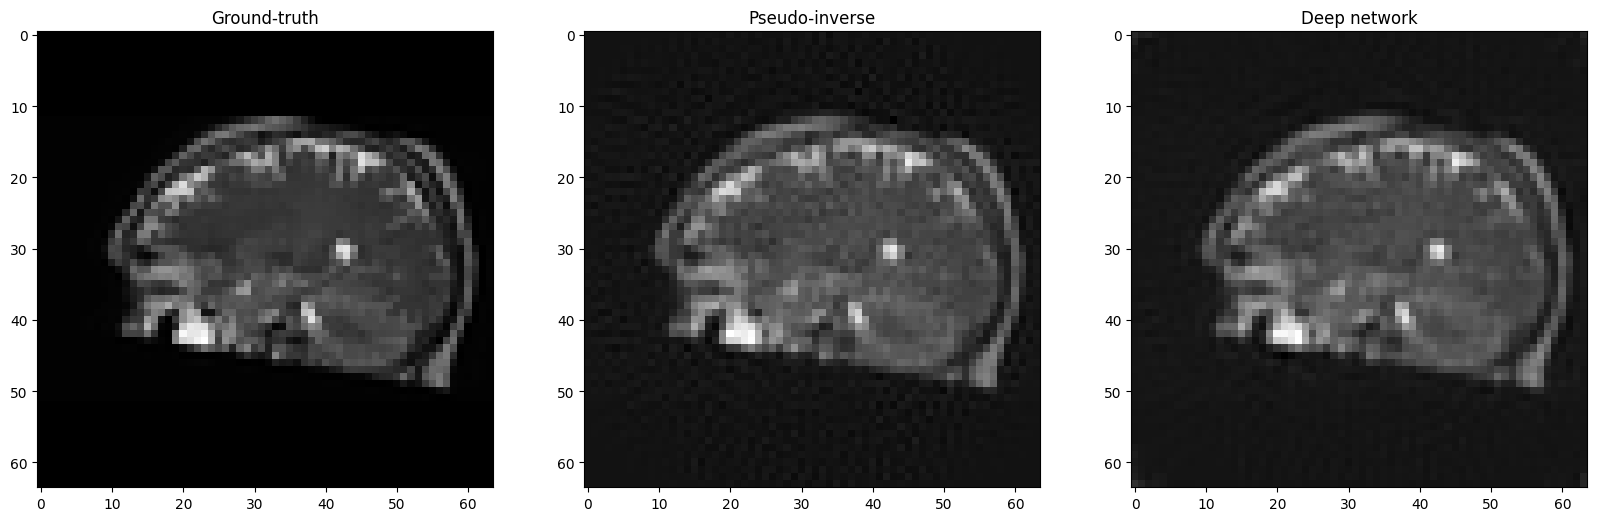

In [23]:
list_angles = [20, 40, 60]
test_batch = 12
c = 0

with torch.no_grad():
    for nbAngles in list_angles:
        
        print(f"Acquisition of {nbAngles} angles")
        
        # Networks filename
        suffix = 'Q_{}_D_{}_T_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format(                   
            img_size, pixel_size, nbAngles, 
            num_epoch, learning_rate, step_size, gamma, batch_size, regularisation)
        title = model_root + 'NET_' + suffix
        
        # loading model
        Areduced = radonSpecifyAngles(A, nbAngles)
        meas = Linear(Areduced, True, reg = 1e-5)
        meas.h, meas.w = img_size, img_size
        noise = NoNoise(meas)        
        prep = DirectPoisson(1.0, meas)
        denoi = ConvNet()
        model = PinvNet(noise, prep, denoi)
        
        model = model.to(device)
        load_net(title, model, device = device)
        
        #==========================================================================
        mes = model.acquire(inputs)
        rec_pinv = model.reconstruct_pinv(mes)
        rec_net = model.reconstruct(mes).detach()

        del model
        
        gt       = inputs[0, 0, :, :].cpu()
        rec_pinv = rec_pinv[0, 0, :, :].cpu()
        rec_net  = rec_net[0, 0, :, :].cpu()
        
        #=======================Plots==============================================
        fig, axs = plt.subplots(1, 3, figsize =(20,10))
        fig.suptitle('', fontsize=16)
        
        ax = axs[0]
        ax.set_title("Ground-truth")
        aff = ax.imshow(gt, cmap='gray') # Complete
        #fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

        ax = axs[1]
        ax.set_title("Pseudo-inverse")
        aff = ax.imshow(rec_pinv, cmap='gray') 
        #fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)

        ax = axs[2]
        ax.set_title("Deep network")
        aff = ax.imshow(rec_net, cmap='gray') 
        #fig.colorbar(aff, ax=ax,fraction=0.046,pad=0.04)
        plt.show()

<font color='blue'>**Q: Conclude on the limitations of deep-neural reconstructors.**</font>

<font color='red'>**A: Deep-neural reconstructors cannot overcome the artefacts resulting from highly undersampled data (i.e., when no information is actually acquired)**</font>


# <span style="color:brown"> **Conclusion**
 

At the end of this hands-on session, you should be able to
* Understand the importance of modeling the forward operator of an inverse problem.
* Reconstruct an image using a linear reconstructor (e.g., Moore-Penrose pseudo-inverse).
* Understand the limitations of linear reconstruction methods for undersampled data (e.g., limited-angle tomography).
* Reconstruct an image using a non-linear reconstructor (e.g., deep convolutional neural networks). 
* Integrate linear reconstructors into a deep-learning method.
* Understand the impact of the training parameters (e.g., the choice of the number of epochs)